Statistical Theory --- Final Project
---
**Family-based Question Notebook**

By Adam Aharony and Adva Davidof.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Reading dataset from csv
df = pd.read_csv("titanic.csv")
# Dropping unnecessary columns
df.drop(
    columns=[
        "PassengerId",
        "Name",
        "Ticket",
        "Cabin",
        "Embarked"
    ],
    inplace=True
)

# Desired data type for certain columns
types = {
    "Survived": "bool",
    "Pclass": "int8",
    "SibSp": "int8",
    "Parch": "int8",
}
for column, dtype in types.items():
    df[column] = df[column].astype(dtype)

# New 'additional family' feature
df["Family"] = df["SibSp"] + df["Parch"]

In [3]:
# Float precision variable, per column
DEFAULT_PRECISION = 2
COLOURS = {
    "blue": "#008AF3",
    "mid_blue": "#006AB2",
    "dark_blue": "#004676",
    "pink": "#FF027A",
    "red": "#B71C1C",
    "green": "#1B5E20"
}

rc = {
    "text.color": "black",
    "axes.labelcolor": "black",
    "legend.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
}

sns.set_theme(
    context="talk",
    style="whitegrid",
    palette="muted",
    rc=rc
)

## Family Statistical Tests
**TODO:** Take care of statistical significance per additional family size (sizes do not have same amount of people)

In [4]:
from scipy.stats import kstest, shapiro, ks_2samp, mannwhitneyu, ranksums, chi2_contingency, fisher_exact, ttest_ind
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.api import Logit
from statsmodels.genmod.generalized_estimating_equations import GEE
from scipy.stats import permutation_test


ALPHA = 5e-2
# Split into survivors and victims
survival_rate_by_family = pd.crosstab(df["Family"], df["Survived"])
family_survivors = df.query("Survived == True")["Family"]
family_victims = df.query("Survived == False")["Family"]
survival_rate_by_family

Survived,False,True
Family,,
0,374,163
1,72,89
2,43,59
3,8,21
4,12,3
5,19,3
6,8,4
7,6,0
10,7,0


### Tests for Normality

#### Kolmogorov-Smirnov Test


In [5]:
def KSTEST(data, description):
    data = data.copy()
    # Standardise data
    data = (data - data.mean()) / data.std()
    # Perform the Kolmogorov-Smirnov test
    statistic, p_value = kstest(data, "norm")
    # Print results
    print(
        f"K-S test for {description}: "
        f"statistic={statistic:.{DEFAULT_PRECISION}f}, "
        f"p-value={p_value:.{DEFAULT_PRECISION}e}"
    )
    # Test interpretation
    if p_value < ALPHA:
        print(f"H_0 can be rejected for {description}.")
    else:
        print(f"H_0 cannot be rejected for {description}.")


tasks = [
    (df["Family"], "additional family on board"),
    (family_survivors, "survivors' additional family on board"),
    (family_victims, "victims' additional family on board")
]

for data, description in tasks:
    KSTEST(data, description)
    print("")

K-S test for additional family on board: statistic=0.32, p-value=3.59e-79
H_0 can be rejected for additional family on board.

K-S test for survivors' additional family on board: statistic=0.26, p-value=3.05e-21
H_0 can be rejected for survivors' additional family on board.

K-S test for victims' additional family on board: statistic=0.37, p-value=1.23e-66
H_0 can be rejected for victims' additional family on board.



#### Shapiro-Wilk Test


In [6]:
def SWTEST(data, description):
    data = data.copy()
    # Perform the Shapiro-Wilk test
    statistic, p_value = shapiro(data)
    # Print results
    print(
        f"Shapiro-Wilk test for {description}: "
        f"statistic={statistic:.{DEFAULT_PRECISION}f}, "
        f"p-value={p_value:.{DEFAULT_PRECISION}e}"
    )
    # Test interpretation
    if p_value < ALPHA:
        print(f"H_0 can be rejected for {description}.")
    else:
        print(f"H_0 cannot be rejected for {description}.")


tasks = [
    (df["Family"], "additional family on board"),
    (family_survivors, "survivors' additional family on board"),
    (family_victims, "victims' additional family on board")
]

for data, description in tasks:
    SWTEST(data, description)
    print("")

Shapiro-Wilk test for additional family on board: statistic=0.62, p-value=1.57e-40
H_0 can be rejected for additional family on board.

Shapiro-Wilk test for survivors' additional family on board: statistic=0.76, p-value=7.26e-22
H_0 can be rejected for survivors' additional family on board.

Shapiro-Wilk test for victims' additional family on board: statistic=0.55, p-value=3.86e-35
H_0 can be rejected for victims' additional family on board.



### Kolmogorov-Smirnov Two-Sample Test 


#### Two-Sided

In [7]:
# Perform the K-S two-sample test
statistic, p_value = ks_2samp(family_survivors, family_victims)

# Print results
print(f"Two-Sided K-S Statistic: {statistic:.{DEFAULT_PRECISION}f}")
print(f"Two-Sided p-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided K-S Statistic: 0.20
Two-Sided p-value: 3.28e-08
H_0 can be rejected.


### Mann-Whitney U Test


#### Two-Sided

In [8]:
# Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(family_survivors, family_victims)

# Print results
print(f"Two-Sided U statistic: {u_statistic:.{DEFAULT_PRECISION}f}")
print(f"Two-Sided P-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided U statistic: 110099.00
Two-Sided P-value: 7.97e-07
H_0 can be rejected.


#### One-Sided

In [9]:
# Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(family_survivors, family_victims, alternative="greater")

# Print results
print(f"One-Sided U statistic: {u_statistic:.{DEFAULT_PRECISION}f}")
print(f"One-Sided P-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

One-Sided U statistic: 110099.00
One-Sided P-value: 3.99e-07
H_0 can be rejected.


### Wilcoxon Rank-Sum Test (with continuity correction)

#### Two-Sided

In [10]:
# Perform Wilcoxon rank-sum test
rank_statistic, p_value = ranksums(family_survivors, family_victims)

# Print results
print(f"Two-Sided Rank statistic: {rank_statistic:.{DEFAULT_PRECISION}f}")
print(f"Two-Sided P-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided Rank statistic: 4.34
Two-Sided P-value: 1.41e-05
H_0 can be rejected.


#### Two-Sided

In [11]:
# Perform Wilcoxon rank-sum test
rank_statistic, p_value = ranksums(family_survivors, family_victims, alternative="greater")

# Print results
print(f"One-Sided Rank statistic: {rank_statistic:.{DEFAULT_PRECISION}f}")
print(f"One-Sided P-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

One-Sided Rank statistic: 4.34
One-Sided P-value: 7.07e-06
H_0 can be rejected.


### Chi-Square Test for Independence

In [12]:
# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(survival_rate_by_family)

# Print results
with np.printoptions(precision=DEFAULT_PRECISION):
    print(f"Chi-Square: {chi2:.{DEFAULT_PRECISION}f}")
    print(f"P-value: {p:.{DEFAULT_PRECISION}e}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected frequencies:\n{expected}")

# Test interpretation
if p < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Chi-Square: 80.67
P-value: 3.58e-14
Degrees of Freedom: 8
Expected frequencies:
[[330.88 206.12]
 [ 99.2   61.8 ]
 [ 62.85  39.15]
 [ 17.87  11.13]
 [  9.24   5.76]
 [ 13.56   8.44]
 [  7.39   4.61]
 [  3.7    2.3 ]
 [  4.31   2.69]]
H_0 can be rejected.


### Fisher's Exact Test


#### Two-Sided

In [13]:
# Since Fisher's Exact Test is designed for 2x2 tables, we split the analysis into pairs
results_table = np.zeros(
    (
        len(survival_rate_by_family.index),
        2
    )
)
# Iterate over all values of family
for i, idx_i in enumerate(survival_rate_by_family.index):
    # Create a 2x2 contingency table
    subtable = survival_rate_by_family.groupby(survival_rate_by_family.index == i).sum()
    # If there are no survivors or victims, add a row of zeros
    if len(subtable) < 2:
        subtable = subtable._append(
            pd.DataFrame(
                [[0, 0]],
                index=~subtable.index,
                columns=subtable.columns
            )
        )
    # Run Fisher's exact test
    results_table[i] = fisher_exact(subtable)

# Print results
with np.printoptions(precision=DEFAULT_PRECISION):
    print(f"Two-Sided Statistics: {results_table[..., 0]}")
    print(f"Two-Sided P-values: {results_table[..., 1]}")
print("Whether H_0 can be rejected:\n", results_table[..., 1] < ALPHA)

# Test interpretation
if np.all(results_table[..., 1] < ALPHA):
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided Statistics: [0.43 2.33 2.45 4.42 0.4  0.25 0.8  0.    nan]
Two-Sided P-values: [1.86e-09 1.77e-06 3.21e-05 2.83e-04 1.84e-01 1.45e-02 1.00e+00 8.77e-02
 1.00e+00]
Whether H_0 can be rejected:
 [ True  True  True  True False  True False False False]
H_0 cannot be rejected.


#### One-Sided

In [14]:
# Since Fisher's Exact Test is designed for 2x2 tables, we split the analysis into pairs
results_table = np.zeros(
    (
        len(survival_rate_by_family.index),
        2
    )
)
# Iterate over all values of family
for i, idx_i in enumerate(survival_rate_by_family.index):
    # Create a 2x2 contingency table
    subtable = survival_rate_by_family.groupby(
        survival_rate_by_family.index == i).sum()
    # If there are no survivors or victims, add a row of zeros
    if len(subtable) < 2:
        subtable = subtable._append(
            pd.DataFrame(
                [[0, 0]],
                index=~subtable.index,
                columns=subtable.columns
            )
        )
    # Run Fisher's exact test
    results_table[i] = fisher_exact(subtable, alternative="greater")

# Print results
with np.printoptions(precision=DEFAULT_PRECISION):
    print(f"One-Sided Statistics: {results_table[..., 0]}")
    print(f"One-Sided P-values: {results_table[..., 1]}")
print("Whether H_0 can be rejected:\n", results_table[..., 1] < ALPHA)

# Test interpretation
if np.all(results_table[..., 1] < ALPHA):
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

One-Sided Statistics: [0.43 2.33 2.45 4.42 0.4  0.25 0.8  0.    nan]
One-Sided P-values: [1.00e+00 1.16e-06 1.84e-05 1.67e-04 9.65e-01 9.98e-01 7.40e-01 1.00e+00
 1.00e+00]
Whether H_0 can be rejected:
 [False  True  True  True False False False False False]
H_0 cannot be rejected.


### Logistic Regression as a Statistical Test


In [15]:
# Create and fit the logistic regression model
model = Logit(
    df["Survived"].copy(),
    df["Family"].copy()
).fit()

# Print p-values
p_value = model.pvalues.iloc[0]
print(f"p-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

model.summary()

Optimization terminated successfully.
         Current function value: 0.688094
         Iterations 4
p-value: 3.54e-03
H_0 can be rejected.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            0
Date:                Sat, 05 Oct 2024   Pseudo R-squ.:                -0.03331
Time:                        19:19:14   Log-Likelihood:                -613.09
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Family        -0.1120      0.038     -2.917      0.004      -0.187      -0.037
==============================================================================
"""

### Test in the Case of Dependent Samples

#### Generalied Estimating Equations (GEE)


In [16]:
# Create and fit the GEE model
model = GEE(
    df["Survived"].copy(),
    df["Family"].copy(),
    groups=df["Family"].copy()
).fit()

# Print p-values
p_value = model.pvalues.iloc[0]
print(f"p-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")
    
model.summary()

p-value: 2.66e-02
H_0 can be rejected.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                    Survived   No. Observations:                  891
Model:                                 GEE   No. clusters:                        9
Method:                        Generalized   Min. cluster size:                   6
                      Estimating Equations   Max. cluster size:                 537
Family:                           Gaussian   Mean cluster size:                99.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Sat, 05 Oct 2024   Scale:                           0.346
Covariance type:                    robust   Time:                         19:19:14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Family         0.1054      0.048      2.217      0.027       0.012       0.199
==============================================================================
Skew:                          0.1881   Kurtosis:                      -1.1666
Centered skew:                 0.4289   Centered kurtosis:             -1.4324
==============================================================================
"""

#### Logistic Regression with Clustered Standard Errors

In [17]:
# Create and fit the logistic regression model
model = Logit(
    df["Survived"].copy(),
    df["Family"].copy()
).fit(
    cov_type="cluster",
    cov_kwds={
        "groups": df["Family"].copy()
    }
)

# Print p-values
p_value = model.pvalues.iloc[0]
print(f"p-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")
    
model.summary()

Optimization terminated successfully.
         Current function value: 0.688094
         Iterations 4
p-value: 1.80e-01
H_0 cannot be rejected.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            0
Date:                Sat, 05 Oct 2024   Pseudo R-squ.:                -0.03331
Time:                        19:19:14   Log-Likelihood:                -613.09
converged:                       True   LL-Null:                       -593.33
Covariance Type:              cluster   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Family        -0.1120      0.084     -1.340      0.180      -0.276       0.052
==============================================================================
"""

#### Permutation Test


##### Two-Sided

In [18]:
N_PERMUTATIONS = 1000
# Initialising with '-1's since some family sizes do not have any survivors or victims
results_table = -1 * np.ones((df["Family"].max(), 2))

# Iterate over all classes
for family_idx in df["Family"].unique():
    # Split the data into the family size of interest
    family_survival = df[df["Family"] == family_idx]["Survived"]
    non_family_survival = df[df["Family"] != family_idx]["Survived"]
    # Perform permuation test
    result = permutation_test(
        data=(family_survival, non_family_survival),
        statistic=lambda c, nc: np.mean(c) - np.mean(nc),
        permutation_type="independent",
        n_resamples=N_PERMUTATIONS,
        alternative="two-sided"
    )
    results_table[family_idx - 1] = result.statistic, result.pvalue

# Print results
with np.printoptions(precision=DEFAULT_PRECISION):
    print(f"Two-Sided Statistics: {results_table[..., 0]}")
    print(f"Two-Sided P-values: {results_table[..., 1]}")
print("Whether H_0 can be rejected:\n", results_table[..., 1] < ALPHA)

# Test interpretation
if np.all(results_table[..., 1] < ALPHA):
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided Statistics: [ 0.21  0.22  0.35 -0.19 -0.25 -0.05 -0.39 -1.   -1.   -0.39]
Two-Sided P-values: [ 0.    0.    0.    0.2   0.02  0.97  0.14 -1.   -1.    0.08]
Whether H_0 can be rejected:
 [ True  True  True False  True False False  True  True False]
H_0 cannot be rejected.


##### One-Sided

In [19]:
N_PERMUTATIONS = 1000
# Initialising with '-1's since some family sizes do not have any survivors or victims
results_table = -1 * np.ones((df["Family"].max(), 2))

# Iterate over all classes
for family_idx in df["Family"].unique():
    # Split the data into the family size of interest
    family_survival = df[df["Family"] == family_idx]["Survived"]
    non_family_survival = df[df["Family"] != family_idx]["Survived"]
    # Perform permuation test
    result = permutation_test(
        data=(family_survival, non_family_survival),
        statistic=lambda c, nc: np.mean(c) - np.mean(nc),
        permutation_type="independent",
        n_resamples=N_PERMUTATIONS,
        alternative="greater"
    )
    results_table[family_idx - 1] = result.statistic, result.pvalue

# Print results
with np.printoptions(precision=DEFAULT_PRECISION):
    print(f"One-Sided Statistics: {results_table[..., 0]}")
    print(f"One-Sided P-values: {results_table[..., 1]}")
print("Whether H_0 can be rejected:\n", results_table[..., 1] < ALPHA)

# Test interpretation
if np.all(results_table[..., 1] < ALPHA):
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

One-Sided Statistics: [ 0.21  0.22  0.35 -0.19 -0.25 -0.05 -0.39 -1.   -1.   -0.39]
One-Sided P-values: [ 9.99e-04  9.99e-04  9.99e-04  9.69e-01  9.98e-01  7.32e-01  1.00e+00
 -1.00e+00 -1.00e+00  1.00e+00]
Whether H_0 can be rejected:
 [ True  True  True False False False False  True  True False]
H_0 cannot be rejected.


## Alone Statistical Tests

In [20]:
from scipy.stats import kstest, shapiro, ks_2samp, mannwhitneyu, ranksums, chi2_contingency, fisher_exact, ttest_ind
from statsmodels.stats.contingency_tables import mcnemar 
from scipy.stats import permutation_test


ALPHA = 5e-2
# Split into survivors and victims
survival_rate_by_alone = pd.crosstab(df["Family"] == 0, df["Survived"])
alone_survivors = df.query("Survived == True")["Family"] == 0
alone_victims = df.query("Survived == False")["Family"] == 0
survival_rate_by_alone

Survived,False,True
Family,,
False,175,179
True,374,163


### Kolmogorov-Smirnov Two-Sample Test 

#### Two-Sided

In [21]:
# Perform the K-S two-sample test
statistic, p_value = ks_2samp(alone_survivors, alone_victims)

# Print results
print(f"Two-Sided K-S Statistic: {statistic:.{DEFAULT_PRECISION}f}")
print(f"Two-Sided p-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided K-S Statistic: 0.20
Two-Sided p-value: 3.28e-08
H_0 can be rejected.


#### One-Sided

In [22]:
# Perform the K-S two-sample test
statistic, p_value = ks_2samp(alone_survivors, alone_victims, alternative="greater")

# Print results
print(f"One-Sided K-S Statistic: {statistic:.{DEFAULT_PRECISION}f}")
print(f"One-Sided p-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

One-Sided K-S Statistic: 0.20
One-Sided p-value: 1.64e-08
H_0 can be rejected.


### Mann-Whitney U Test


#### Two-Sided

In [23]:
# Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(alone_survivors, alone_victims)

# Print results
print(f"Two-Sided U statistic: {u_statistic:.{DEFAULT_PRECISION}f}")
print(f"Two-Sided P-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided U statistic: 74668.50
Two-Sided P-value: 1.30e-09
H_0 can be rejected.


#### One-Sided

In [24]:
# Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(alone_survivors, alone_victims, alternative="less")

# Print results
print(f"One-Sided U statistic: {u_statistic:.{DEFAULT_PRECISION}f}")
print(f"One-Sided P-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

One-Sided U statistic: 74668.50
One-Sided P-value: 6.52e-10
H_0 can be rejected.


### Wilcoxon Rank-Sum Test (with continuity correction)

#### Two-Sided

In [25]:
# Perform Wilcoxon rank-sum test
rank_statistic, p_value = ranksums(alone_survivors, alone_victims)

# Print results
print(f"Two-Sided Rank statistic: {rank_statistic:.{DEFAULT_PRECISION}f}")
print(f"Two-Sided P-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided Rank statistic: -5.14
Two-Sided P-value: 2.72e-07
H_0 can be rejected.


#### One-Sided

In [26]:
# Perform Wilcoxon rank-sum test
rank_statistic, p_value = ranksums(alone_survivors, alone_victims, alternative="less")

# Print results
print(f"One-Sided Rank statistic: {rank_statistic:.{DEFAULT_PRECISION}f}")
print(f"One-Sided P-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

One-Sided Rank statistic: -5.14
One-Sided P-value: 1.36e-07
H_0 can be rejected.


### Chi-Square Test for Independence



In [27]:
# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(survival_rate_by_alone)

# Print results
with np.printoptions(precision=DEFAULT_PRECISION):
    print(f"Chi-Square: {chi2:.{DEFAULT_PRECISION}f}")
    print(f"P-value: {p:.{DEFAULT_PRECISION}e}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected frequencies:\n{expected}")

# Test interpretation
if p < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Chi-Square: 36.00
P-value: 1.97e-09
Degrees of Freedom: 1
Expected frequencies:
[[218.12 135.88]
 [330.88 206.12]]
H_0 can be rejected.


### Fisher's Exact Test


#### Two-Sided

In [28]:
# Perform Fisher's Exact Test 
odds_ratio, p_value = fisher_exact(survival_rate_by_alone)

# Print results
print(f"Two-Sided Odds Ratio: {odds_ratio:.{DEFAULT_PRECISION}f}")
print(f"Two-Sided P-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided Odds Ratio: 0.43
Two-Sided P-value: 1.86e-09
H_0 can be rejected.


#### One-Sided

In [29]:
# Perform Fisher's Exact Test 
odds_ratio, p_value = fisher_exact(survival_rate_by_alone, alternative="less")

# Print results
print(f"One-Sided Odds Ratio: {odds_ratio:.{DEFAULT_PRECISION}f}")
print(f"One-Sided P-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

One-Sided Odds Ratio: 0.43
One-Sided P-value: 1.06e-09
H_0 can be rejected.


### Test in the Case of Dependent Samples

#### Permutation Test

##### Two-Sided

In [30]:
N_PERMUTATIONS = 1000

# Split the data into the class of interest
alone_survival = df[df["Family"] == 0]["Survived"]
non_alone_survival = df[df["Family"] != 0]["Survived"]
# Perform permuation test
result = permutation_test(
    data=(alone_survival, non_alone_survival),
    statistic=lambda c, nc: np.mean(c) - np.mean(nc),
    permutation_type="independent",
    n_resamples=N_PERMUTATIONS,
    alternative="two-sided"
)

# Print results
print(f"Two-Sided Statistic: {result.statistic:.{DEFAULT_PRECISION}e}")
print(f"Two-Sided P-value: {result.pvalue:.{DEFAULT_PRECISION}e}")

# Test interpretation
if result.pvalue < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided Statistic: -2.02e-01
Two-Sided P-value: 2.00e-03
H_0 can be rejected.


##### One-Sided

In [31]:
N_PERMUTATIONS = 1000

# Split the data into the class of interest
alone_survival = df[df["Family"] == 0]["Survived"]
non_alone_survival = df[df["Family"] != 0]["Survived"]
# Perform permuation test
result = permutation_test(
    data=(alone_survival, non_alone_survival),
    statistic=lambda c, nc: np.mean(c) - np.mean(nc),
    permutation_type="independent",
    n_resamples=N_PERMUTATIONS,
    alternative="less"
)

# Print results
print(f"One-Sided Statistic: {result.statistic:.{DEFAULT_PRECISION}e}")
print(f"One-Sided P-value: {result.pvalue:.{DEFAULT_PRECISION}e}")

# Test interpretation
if result.pvalue < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

One-Sided Statistic: -2.02e-01
One-Sided P-value: 9.99e-04
H_0 can be rejected.


## People per Family on Board

### People per Family on Board (raw)

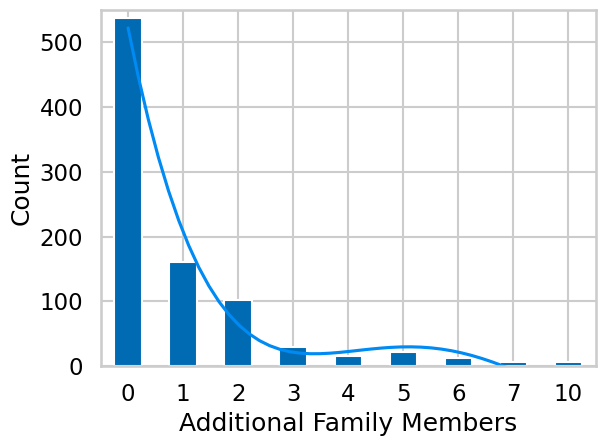

In [32]:
# Calculate the count of people per family
people_per_family = df["Family"].value_counts().sort_index()

fig, ax = plt.subplots()

# Plot the count of people per family
people_per_family.plot(
    kind="bar",
    xlabel="Additional Family Members",
    ylabel="Count",
    color=COLOURS["mid_blue"],
    ax=ax
)
# Rotate the x-axis labels
plt.xticks(rotation=0)
# Get x values of the ax bars
x_values = np.sort(df["Family"].unique())
# Get y values of the ax bars
y_values = tuple(map(lambda p: p.get_height(), ax.patches))
# Plot approximation
c = np.polyfit(x_values, y_values, 4)
x = np.linspace(0, len(people_per_family.index), 50)
y = np.polyval(c, x)
ax.plot(x, y, color=COLOURS["blue"])
plt.ylim(0, 550)

# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/family_raw.pdf", bbox_inches="tight")
plt.savefig("figures/family_raw.pgf", bbox_inches="tight")

### People per Family on Board (normalised)

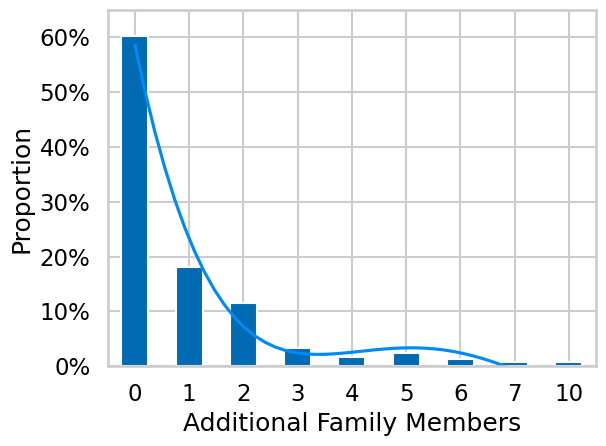

In [33]:
# Calculate the rate of people per family
people_per_family = df["Family"].value_counts(normalize=True).sort_index()

plt.figure()
# Plot the count of people per family
people_per_family.plot(
    kind="bar",
    xlabel="Additional Family Members",
    ylabel="Proportion",
    color=COLOURS["mid_blue"]
)
# Calculate approximation
c = np.polyfit(people_per_family.index, people_per_family.values, 4)
x = np.linspace(0, len(people_per_family.index), 50)
y = np.polyval(c, x)
plt.plot(x, y, color=COLOURS["blue"])
# Rotate the x-axis labels
plt.xticks(rotation=0)
# Change y-labels to percentages
y_ticks = [f"{y:.0%}" for y in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], y_ticks)
plt.ylim(0, 0.65)

# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/family_normalised.pdf", bbox_inches="tight")
plt.savefig("figures/family_normalised.pgf", bbox_inches="tight")

## Survival Rate by Family on Board

### Categorical: Amount of Additional Family

#### Survival rate by family on board (raw)

In [34]:
# Calculate the survival rate by family
survival_rate_by_family = pd.crosstab(df["Family"], df["Survived"])

# Format the index and columns of the dataframe
styler = survival_rate_by_family.style
styler.format_index("\\textbf{{{}}}", axis=0, escape="latex")
styler.format_index("\\textbf{{{}}}", axis=1, escape="latex")
# Convert the dataframe to LaTeX and save it as a table
styler.to_latex("tables/survival-family_raw.tex", hrules=True)

# Display the survival rate by family dataframe
survival_rate_by_family

Survived,False,True
Family,,
0,374,163
1,72,89
2,43,59
3,8,21
4,12,3
5,19,3
6,8,4
7,6,0
10,7,0


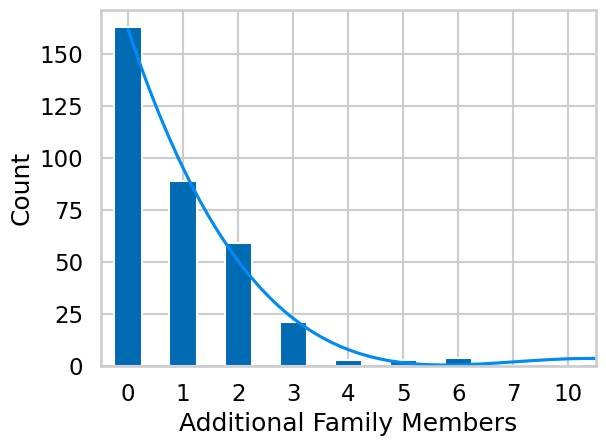

In [35]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the survival rate by family
survival_rate_by_family[True].plot(
    kind="bar",
    xlabel="Additional Family Members",
    ylabel="Count",
    color=COLOURS["mid_blue"],
    ax=ax
)
# Rotate the x-axis labels
plt.xticks(rotation=0)
# Get x values of the ax bars
x_values = np.sort(df["Family"].unique())
# Get y values of the ax bars
y_values = tuple(map(lambda p: p.get_height(), ax.patches))
# Plot approximation
c = np.polyfit(x_values, y_values, 4)
x = np.linspace(0, len(survival_rate_by_family.index), 50)
y = np.polyval(c, x)
ax.plot(x, y, color=COLOURS["blue"])

# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/survival-family_raw.pdf", bbox_inches="tight")
plt.savefig("figures/survival-family_raw.pgf", bbox_inches="tight")

#### Survival rate by family on board (normalised)

In [36]:
# Calculate the survival count by family
survival_rate_by_family = pd.crosstab(df["Family"], df["Survived"], normalize="index")

# Format the index and columns of the dataframe
styler = survival_rate_by_family.style
styler.format_index("\\textbf{{{}}}", axis=0, escape="latex")
styler.format_index("\\textbf{{{}}}", axis=1, escape="latex")
# Format the values in the dataframe
styler.format(
    subset=None,
    formatter=lambda x: f"{100*x:.{DEFAULT_PRECISION}f}"+"\%"
)
# Convert the dataframe to LaTeX and save it as a table
styler.to_latex("tables/survival-family_normalised.tex", hrules=True)

# Display the survival rate by family dataframe
survival_rate_by_family

Survived,False,True
Family,,
0,0.696462,0.303538
1,0.447205,0.552795
2,0.421569,0.578431
3,0.275862,0.724138
4,0.800000,0.200000
5,0.863636,0.136364
6,0.666667,0.333333
7,1.000000,0.000000
10,1.000000,0.000000


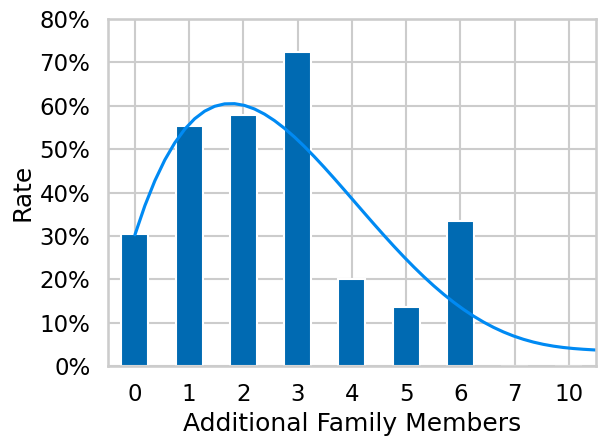

In [37]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the survival rate by family on board (normalised)
survival_rate_by_family[True].plot(
    xlabel="Additional Family Members",
    ylabel="Rate",
    kind="bar",
    stacked=False,
    color=COLOURS["mid_blue"],
    ax=ax
)
# Rotate x-axis labels
plt.xticks(rotation=0)
# Change y-labels to percentages
y_ticks = [f"{y:.0%}" for y in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], y_ticks)

# Plot approximation
c = np.polyfit(df["Family"], df["Survived"], 4)
x = np.linspace(0, len(survival_rate_by_family.index), 50)
y = np.polyval(c, x)
ax.set_ylim(0, 0.8)
ax.plot(x, y, color=COLOURS["blue"])

# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/survival-family_normalised.pdf", bbox_inches="tight")
plt.savefig("figures/survival-family_normalised.pgf", bbox_inches="tight")

### Binary: Alone or Together

#### Survival rate by alone or together (raw)

In [38]:
# Calculate the survival count by alone
survival_rate_by_alone = pd.crosstab(df["Family"] == 0, df["Survived"])#survival_rate_by_family.groupby(survival_rate_by_family.index == 0).sum()

# Format the index and columns of the dataframe
styler = survival_rate_by_alone.style
styler.format_index("\\textbf{{{}}}", axis=0, escape="latex")
styler.format_index("\\textbf{{{}}}", axis=1, escape="latex")
styler.format(subset=None, precision=0)
# Convert the dataframe to LaTeX and save it as a table
styler.to_latex("tables/survival-alone_raw.tex", hrules=True)

# Display the survival rate by alone dataframe
survival_rate_by_alone

Survived,False,True
Family,,
False,175,179
True,374,163


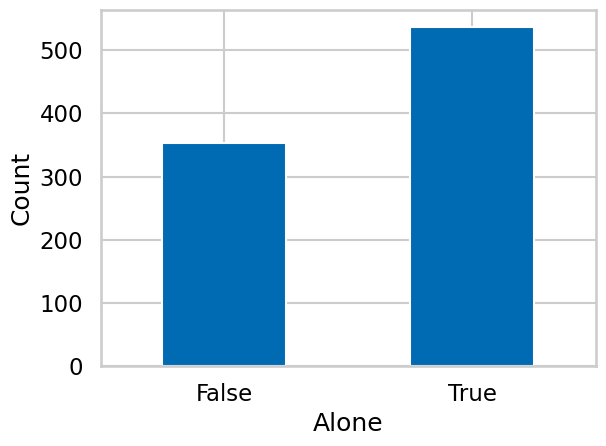

In [39]:
toplot = survival_rate_by_alone.sum(axis=1)
toplot.plot(
    kind="bar",
    xlabel="Alone",
    ylabel="Count",
    color=COLOURS["mid_blue"]
)
# Rotate x-axis labels
plt.xticks(rotation=0)
# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/alone_raw.pdf", bbox_inches="tight")
plt.savefig("figures/alone_raw.pgf", bbox_inches="tight")

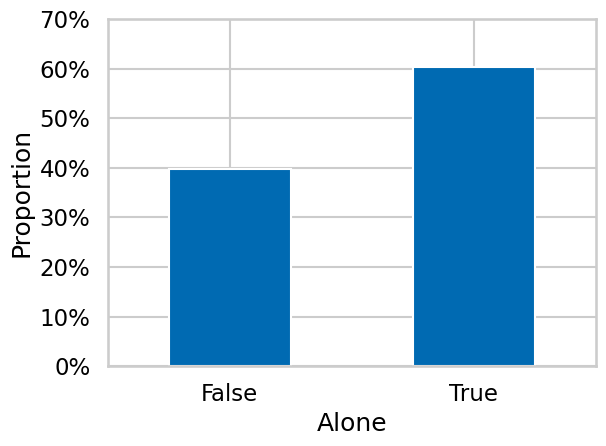

In [40]:
toplot = survival_rate_by_alone.sum(axis=1)
toplot /= toplot.sum()
toplot.plot(
    kind="bar",
    xlabel="Alone",
    ylabel="Proportion",
    color=COLOURS["mid_blue"]
)
# Rotate x-axis labels
plt.xticks(rotation=0)
# Change y-labels to percentages
y_ticks = [f"{y:.0%}" for y in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], y_ticks)
# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/alone_normalised.pdf", bbox_inches="tight")
plt.savefig("figures/alone_normalised.pgf", bbox_inches="tight")

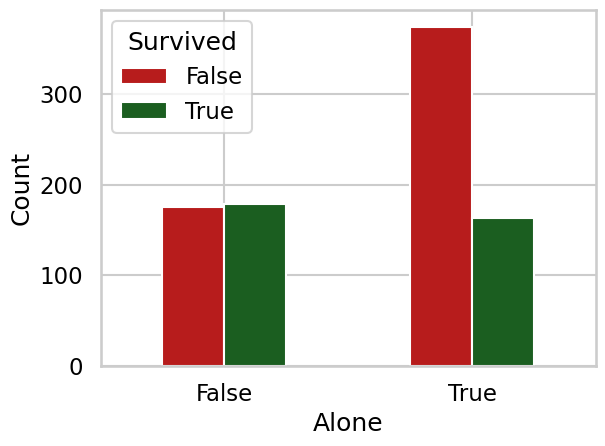

In [41]:
# Plot the survival rate by alone or together (raw)
survival_rate_by_alone.plot(
    xlabel="Alone",
    ylabel="Count",
    kind="bar",
    stacked=False,
    color=[COLOURS["red"], COLOURS["green"]]
)
# Rotate x-axis labels
plt.xticks(rotation=0)

# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/survival-alone_raw.pdf", bbox_inches="tight")
plt.savefig("figures/survival-alone_raw.pgf", bbox_inches="tight")

#### Survival rate by alone or together (normalised)

In [42]:
# Calculate the survival rate by alone
survival_rate_by_alone = pd.crosstab(df["Family"] == 0, df["Survived"], normalize="index")

# Format the index and columns of the dataframe
styler = survival_rate_by_alone.style
styler.format_index("\\textbf{{{}}}", axis=0, escape="latex")
styler.format_index("\\textbf{{{}}}", axis=1, escape="latex")
styler.format(
    subset=None,
    formatter=lambda x: f"{100*x:.{DEFAULT_PRECISION}f}"+"\%"
)
# Convert the dataframe to LaTeX and save it as a table
styler.to_latex("tables/survival-alone_normalised.tex", hrules=True)

# Display the survival rate by alone dataframe
survival_rate_by_alone

Survived,False,True
Family,,
False,0.494350,0.505650
True,0.696462,0.303538


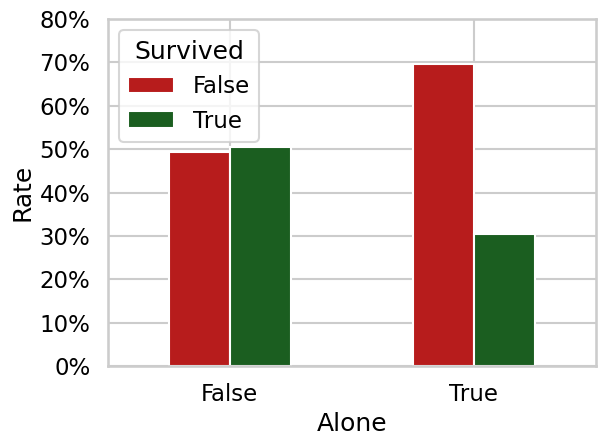

In [43]:
# Plot the survival rate by alone or together (normalised)
survival_rate_by_alone.plot(
    xlabel="Alone",
    ylabel="Rate",
    kind="bar",
    stacked=False,
    color=[COLOURS["red"], COLOURS["green"]]
)
# Change y-labels to percentages
y_ticks = [f"{y:.0%}" for y in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], y_ticks)
# Rotate x-axis labels
plt.xticks(rotation=0)

# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/survival-alone_normalised.pdf", bbox_inches="tight")
plt.savefig("figures/survival-alone_normalised.pgf", bbox_inches="tight")